Combustion Engines identification using Machine Learning techniques

USP Esalq - MBA Data Science & Analytics - 2022/2

Matheus Felipe Sozza

# 1. Install and Import libraries

In [1]:
# Import modules
%matplotlib inline
import dill
import sys
import numpy as np
import librosa
import librosa.display
import pandas as pd
import os
import scipy.signal
import math
import shelve

from IPython.display import Audio

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten
from keras.utils.vis_utils import plot_model
from keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

# Custom library created for the project
import soundDetection_AuxiliarFunctions

# 2. Map **Audio** files and **Metadata** from file system. Define some **hyperparameters**

In [2]:
# Path related variables
PATH_PROJECT = 'C:/Users/SZM1JVL/Documents/PESSOAL - MBA DSA TCC/'
PATH_METADATA_FILE = PATH_PROJECT + 'DatasetMapping.csv'
PATH_AUDIOS = PATH_PROJECT + 'UrbanSounds8k/audio/'
PATH_NUM_SUBFOLDERS = 10

# Audio processing variables
AUDIO_SR = 44100 # Audio sampling in Hertz
AUDIO_N_FFT = 2048 # Samples per FFT window
AUDIO_HOP_LEN = 512
AUDIO_N_MELS = 26

# Audio segmentation variables
AUDIOSEG_SIZE = 22050 # samples per segment (500ms)
AUDIOSEG_OVERLAP = 0.5 # normalized

# Debug and test variables
REDUCED_MODE = 1  # Do not process all the audio in the dataset (for faster execution during script development)
REDUCED_MODE_AUDIONUM = 500 # Number of dataset audios to process in the reduced-mode.

# Use variables stored on shelves
SHELF_USE = 0

# 3. **Audios Dataset** creation (Pandas Table)

In [3]:
def saveShelf(filename, filepath, var2Save):
    shelf = shelve.open(filepath  + filename + '.out', 'n')
    shelf[filename] = var2Save
    shelf.close()

def loadShelf(filename, filepath):
    shelf = shelve.open(filepath  + filename + '.out')
    returnVar = shelf[filename]
    shelf.close()
    return returnVar

In [4]:
# Create an audio dataframe with all audios metadata and file name/path 

if SHELF_USE == 1: # Retrieve from shelf instead of processing again
    audio_DF = loadShelf('audio_DF', PATH_PROJECT + 'workspace/');
else:
    audio_DF = soundDetection_AuxiliarFunctions.createAudiosDataset(PATH_METADATA_FILE, PATH_AUDIOS)

    if REDUCED_MODE ==1: # Reduced mode early stop (test purpose)
        audio_DF = audio_DF[0:REDUCED_MODE_AUDIONUM]

    # Save the result on a shelf
    saveShelf('audio_DF', PATH_PROJECT + 'workspace/', audio_DF);

audio_DF.head()

C:/Users/SZM1JVL/Documents/PESSOAL - MBA DSA TCC/UrbanSounds8k/audio/fold5/100032-3-0-0.wav  ---> Index:  0
C:/Users/SZM1JVL/Documents/PESSOAL - MBA DSA TCC/UrbanSounds8k/audio/fold1/122690-6-0-0.wav  ---> Index:  1000
C:/Users/SZM1JVL/Documents/PESSOAL - MBA DSA TCC/UrbanSounds8k/audio/fold2/147926-0-0-44.wav  ---> Index:  2000
C:/Users/SZM1JVL/Documents/PESSOAL - MBA DSA TCC/UrbanSounds8k/audio/fold6/162434-6-2-0.wav  ---> Index:  3000
C:/Users/SZM1JVL/Documents/PESSOAL - MBA DSA TCC/UrbanSounds8k/audio/fold5/178260-7-1-9.wav  ---> Index:  4000
C:/Users/SZM1JVL/Documents/PESSOAL - MBA DSA TCC/UrbanSounds8k/audio/fold4/195969-0-0-19.wav  ---> Index:  5000
C:/Users/SZM1JVL/Documents/PESSOAL - MBA DSA TCC/UrbanSounds8k/audio/fold3/30204-0-0-11.wav  ---> Index:  6000
C:/Users/SZM1JVL/Documents/PESSOAL - MBA DSA TCC/UrbanSounds8k/audio/fold2/60605-9-0-90.wav  ---> Index:  7000
C:/Users/SZM1JVL/Documents/PESSOAL - MBA DSA TCC/UrbanSounds8k/audio/fold2/77751-4-9-1.wav  ---> Index:  8000
Num

,path,filename,fold,duration,class,classID,isEngine
0,C:/Users/SZM1JVL/Documents/PESSOAL - MBA DSA T...,100032-3-0-0.wav,5,0.317551,dog_bark,3,0
1,C:/Users/SZM1JVL/Documents/PESSOAL - MBA DSA T...,100263-2-0-117.wav,5,4.000000,children_playing,2,0
2,C:/Users/SZM1JVL/Documents/PESSOAL - MBA DSA T...,100263-2-0-121.wav,5,4.000000,children_playing,2,0
3,C:/Users/SZM1JVL/Documents/PESSOAL - MBA DSA T...,100263-2-0-126.wav,5,4.000000,children_playing,2,0
4,C:/Users/SZM1JVL/Documents/PESSOAL - MBA DSA T...,100263-2-0-137.wav,5,4.000000,children_playing,2,0


In [5]:
# Audios histogram per type
#audio_DF['isEngine'].plot.hist(bins=12, alpha=0.5);

In [6]:
# Audios histogram per duration
#audio_DF['duration'].plot.hist(bins=12, alpha=0.5);
#audio_DF.plot.hist(column=["duration"],by="class", bins=4, alpha=1, figsize=(10, 25));

# 4. **Audios Compilation** creation (audios '.wav' **'array-of-arrays'**)

In [7]:
# Compile all audios in an array of audios (save on a shelf too)
audio_AA = [] # Audio "array of arrays" (AA) - all audios in one object

if SHELF_USE == 1: # Retrieve from shelf instead of processing again
    audio_AA = loadShelf('audio_AA', PATH_PROJECT + 'workspace/');
else:
    # Append all the audio arrays in a single array
    for idx, rowData in audio_DF.iterrows():
        if(idx%1000 == 0): #Feedback
            print(idx)

        folderNum = audio_DF['fold'][idx];
        tmp_A = soundDetection_AuxiliarFunctions.loadAudioTrack( audio_DF['path'][idx], arg_sr = AUDIO_SR);
        audio_AA.append(tmp_A); # Append audio data to a single array

        if REDUCED_MODE ==1 and idx == REDUCED_MODE_AUDIONUM : # Reduced mode early stop (test purpose)
            break;

    # Save the result on a shelf
    saveShelf('audio_AA', PATH_PROJECT + 'workspace/', audio_AA);

0


# 5. **Segmented audios** subset  & dataframe creation (**data augmentation**)

In [8]:
segAudio_AA = [] ## Subsegmented Audio "array of arrays" (AA) - all segmented audios in one object
segAudio_DF = pd.DataFrame(); #[] # Array containing the information if the audio is an engine

if SHELF_USE == 1:
    segAudio_AA = loadShelf('segAudio_AA', PATH_PROJECT + 'workspace/');
    segAudio_DF = loadShelf('segAudio_DF', PATH_PROJECT + 'workspace/');
else:
    # Prepare the loop through all audios
    idxAudio = 0
    for audio in audio_AA:
        # Extract data from 'audio'
        tmp_AA = []
        tmp_DF = []
        tmp_AA, tmp_DF = soundDetection_AuxiliarFunctions.extractAudioSubset(audio, 
        audio_DF.loc[idxAudio], AUDIOSEG_OVERLAP, AUDIOSEG_SIZE, AUDIO_SR)

        # Concatenate in a single dataset array all 'segmented audios' + 'isEngine' classification
        segAudio_AA = segAudio_AA + tmp_AA #Concatenate
        segAudio_DF = pd.concat([segAudio_DF, tmp_DF]);
        
        idxAudio = idxAudio+1

    saveShelf('segAudio_AA', PATH_PROJECT + 'workspace/', segAudio_AA);
    saveShelf('segAudio_DF', PATH_PROJECT + 'workspace/', segAudio_DF);

# 6. **Segmented audios** normalization

In [9]:
# Normalizing dataset using 'Sklearn Normalization' with 'Max' method
segAudioNorm_AA = preprocessing.normalize(segAudio_AA, norm='max')

# 7. **Train and Test** Split + **CNN** training

The audios are originally split (randomly) in 10 different folders. The intent is train the network with 8/9 folders and test it with 1/2 folder. The process shall be repeated changing which are the folders assigned to be 'training' and 'testing' folders.

In [10]:
train_DF, test_DF, x_train_AA, x_test_AA = soundDetection_AuxiliarFunctions.trainTestFolder([1], segAudio_DF, segAudio_AA)

# Reference data (Y) to one-hot enconding
y_train_A = to_categorical(train_DF['isEngine']);
y_test_A = to_categorical(test_DF['isEngine']);

The CNN will receive samples of nMels vs. segSize (26 per 22050 'sound images')


In [11]:
# Transform audios array in spectograms array (AA to AM, or 1D to 2D)
# Generation of the 'sound images' -> 'nMels' per 'samples/hopLength'
x_train_AM = [];
x_test_AM = [];

idx=0
for audio in x_train_AA:
    tmp_AM = librosa.feature.melspectrogram(y=x_train_AA[idx], hop_length= AUDIO_HOP_LEN, n_fft=AUDIO_N_FFT, n_mels = AUDIO_N_MELS, sr=AUDIO_SR);
    x_train_AM.append(tmp_AM);
    idx=idx+1

idx=0
for audio in x_test_AA:
    tmp_AM = librosa.feature.melspectrogram(y=x_test_AA[idx], hop_length= AUDIO_HOP_LEN, n_fft=AUDIO_N_FFT, n_mels = AUDIO_N_MELS, sr=AUDIO_SR);
    x_test_AM.append(tmp_AM);    
    idx=idx+1

In [12]:
# Num of 'images' vs. n_mels vs. samples/hopLen
print('x_train_AM shape:')
print('   -->' , np.shape(x_train_AM))
print('x_test_AM shape:')
print('   -->' , np.shape(x_test_AM))

x_train_AM shape:
   --> (6318, 26, 44)
x_test_AM shape:
   --> (918, 26, 44)


In [21]:
np.ceil(4.01)

5.0

In [24]:
# Reshaping data for inputting in the neural network
print(len(x_train_AM))
x_train_AM = np.array(x_train_AM)
x_train_AM = x_train_AM.reshape(len(x_train_AM), 
            AUDIO_N_MELS , 
            int(np.ceil(AUDIOSEG_SIZE/AUDIO_HOP_LEN)),
            1)

print(len(x_test_AM))
x_test_AM = np.array(x_test_AM)
x_test_AM = x_test_AM.reshape(len(x_test_AM),
            AUDIO_N_MELS , 
            int(np.ceil(AUDIOSEG_SIZE/AUDIO_HOP_LEN)),
            1)

6318
918


In [14]:
# CNN Model
CNN_model = Sequential()

# Layers adding to CNN
CNN_model.add(Conv2D(10, name= "C1", kernel_size=8, activation='relu', input_shape=(28,28,1)))

# A. Appendix 1 - Engine examples and plots

In [15]:
# Engine Audio Example
Audio(segAudioNorm_AA[1960], rate=AUDIO_SR)

Text(80.77777777777779, 0.5, 'Signal')

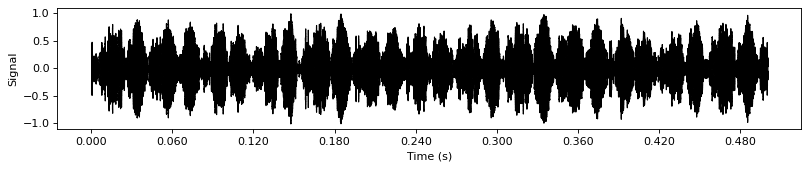

In [16]:
# Plot Audio signal
figure(figsize=(12,2), dpi=80)
librosa.display.waveshow(segAudioNorm_AA[1960], sr= AUDIO_SR, color='black')
plt.xlabel('Time (s)')
plt.ylabel('Signal')

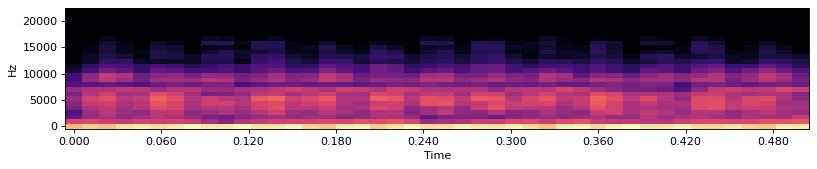

In [17]:
# Engine Spectogram example
figure(figsize=(12,2), dpi=80)
img_Spect = librosa.feature.melspectrogram(y=segAudioNorm_AA[1958], n_mels = AUDIO_N_MELS, sr=AUDIO_SR)
img_Spect = librosa.amplitude_to_db(img_Spect, ref=np.max)
librosa.display.specshow(img_Spect, y_axis='linear', x_axis='time', sr=AUDIO_SR);

In [18]:
# Engine Audio Example 2
Audio(segAudioNorm_AA[7068], rate=AUDIO_SR)

AttributeError: 'Line2D' object has no property 'n_mels'

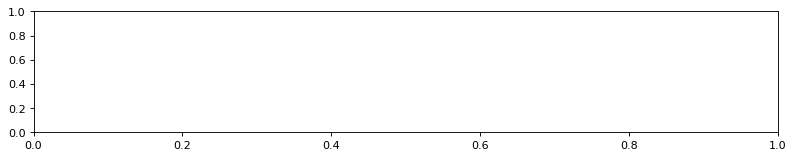

In [19]:
# Plot Audio signal 2
figure(figsize=(12,2), dpi=80)
librosa.display.waveshow(segAudioNorm_AA[7068], sr= AUDIO_SR, n_mels = AUDIO_N_MELS, color='black')
plt.xlabel('Time (s)')
plt.ylabel('Signal')

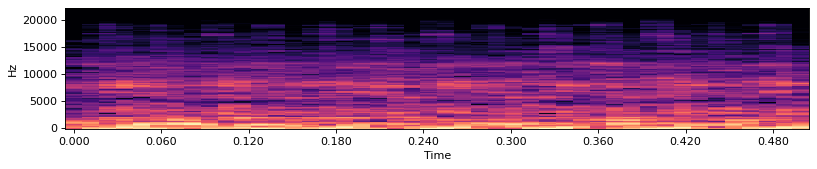

In [ ]:
# Engine Spectogram example 2
figure(figsize=(12,2), dpi=80)
img_Spect = librosa.feature.melspectrogram(y=segAudioNorm_AA[7068], sr=AUDIO_SR)
img_Spect = librosa.amplitude_to_db(img_Spect, ref=np.max)
librosa.display.specshow(img_Spect, y_axis='linear', x_axis='time', sr=AUDIO_SR, )